## Settings

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly import tools
import scipy.stats as sp
from scipy.optimize import fmin
from scipy.optimize import minimize
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
apiKey = 'lQg24SpLGpWSL3Yn35VS'
plotly.tools.set_credentials_file(username='amcdonne', api_key=apiKey)
plotly.tools.set_config_file(world_readable=False, sharing='private')

# (i) Firm Value

### (a) Simulate the value of the firm 250,000 times over a 20 year period using the Merton Model

In [1]:
'''
V: Starting Firm Value @ t_0
K: Face Value of Debt @ T (Strike Price) **** Variable not used in the model
sigma: The Volatility of Assets or Firm value for a specified time period
dt: Time Step
iRate: Quoted Annual Interest Rate
num_paths: The number of paths that will be simulated

Notes: Model starts with the given details of Firm value and then generates a monte carlo simulation based on the number of paths,
scaled volatility, time step and interest rate
'''
def merton_model(V, K, sigma, T, dt, iRate, num_paths):
    num_periods = int(T*dt**-1)
    #Creates a matrix filled with zeros; Rows: num_paths, Columns: num_periods
    asset_value = np.zeros((num_periods + 1, int(num_paths)))
    asset_value[0] = V
    for t in range(1, num_periods+1):
        if t > num_periods/2:
            sigma = .25
        # The stochastic equation for simulating the firm value
        asset_value[t] = asset_value[t-1]*np.exp((iRate -.5*sigma**2)*dt + sigma*np.random.randn(num_paths)*np.sqrt(dt))
    return asset_value

In [5]:
simulated_asset_values = merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)
print('Base Model Output: ', simulated_asset_values, '\n')
print('PD Output 1: ', merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000), '\n')
print('PD Output 2: ', merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000), '\n')
print('PD Output 3: ', merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000), '\n')
print('PD Output 4: ', merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000))

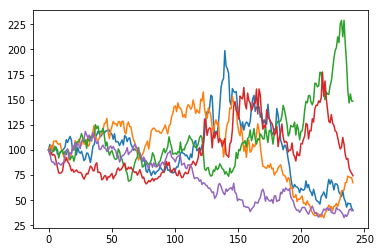

In [6]:
# Faster more effiecient plotting for randomly selected paths; not as clean of a plot as the other though
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 241, num=241)
ax.plot(x, simulated_asset_values[:,np.random.randint(250000)],
         x, simulated_asset_values[:,np.random.randint(250000)],
         x, simulated_asset_values[:,np.random.randint(250000)],
         x, simulated_asset_values[:,np.random.randint(250000)],
         x, simulated_asset_values[:,np.random.randint(250000)])

In [7]:
# Plotly Chart for 5 randomly selected simulated Merton Model asset values
trace0 = go.Scatter(
    y = simulated_asset_values[:,np.random.randint(250000)],
    mode = 'lines',
    name = 'Path 1'
)
trace1 = go.Scatter(
    y = simulated_asset_values[:,np.random.randint(250000)],
    mode = 'lines',
    name = 'Path 2'
)
trace2 = go.Scatter(
    y = simulated_asset_values[:,np.random.randint(250000)],
    mode = 'lines',
    name = 'Path 3'
)
trace3 = go.Scatter(
    y = simulated_asset_values[:,np.random.randint(250000)],
    mode = 'lines',
    name = 'Path 4'
)
trace4 = go.Scatter(
    y = simulated_asset_values[:,np.random.randint(250000)],
    mode = 'lines',
    name = 'Path 5'
)
data = [trace0, trace1, trace2, trace3, trace4]
layout = dict(title = 'Asset Value Simulation',
              xaxis = dict(title = 'Time Period in months'),
              yaxis = dict(title = 'Asset Value'),
              )

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Credit-Risk-Merton_Monte_Carlo')

C:\Users\austi\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### (b) Plot Residual Firm Values

In [8]:
# Calculate the simple residual firm values by subtracting the face value of debt from the simulated asset values
residual_firm_value = simulated_asset_values - 80

# Plotly Histogram chart of the residual asset values @ Maturity (T=T)
data = [go.Histogram(x=residual_firm_value[-1,:])]
layout = dict(title = 'Asset Values at T Histogram',
              xaxis = dict(title = 'Number of observations'),
              yaxis = dict(title = 'Asset Value'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Credit-Risk-Merton_Distribution')

C:\Users\austi\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



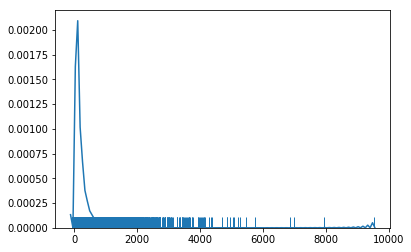

In [10]:
# Seaborn plot of the residual asset values @ Maturity T=T
sns.distplot(residual_firm_value[-1,:], hist=False, rug=True);

### (c) Default Probability @ T

In [25]:
'''
Notes: Calculates the "Analytical Default Probability" based on the values of N(-d2) derived from the Call option from the Equity
calculation. This accounts for the split sigma's given at 10 year intervals

TODO: Check to see if the variances can be combined or D2's multiplied together
'''

def analytical_default_probability(V_0, K, sigma_10, sigma_20, T, iRate):
    
    d1_10 = (np.log(V_0/K) + (iRate + .5*sigma_10**2)*T)/ (sigma_10*np.sqrt(T))
    d2_10 = d1_10 - (sigma_10)*np.sqrt(T)
    d1_20 = (np.log(V_0/K) + (iRate + .5*sigma_20**2)*T)/ (sigma_20*np.sqrt(T))
    d2_20 = d1_20 - (sigma_20)*np.sqrt(T)
    
    return print('Product of multiple leg Probability of Default: ', np.prod([d2_10, d2_20]))
    #print(sp.norm.pdf(d1))
    #print(sp.norm.pdf(d2))
    #print(sp.norm.pdf(-d2))
    #equity_0 = V_0*sp.norm.cdf(d1) - K*np.exp(-iRate*T)*sp.norm.cdf(d2)
    #return ('Call Option Price: ' + str(round(equity_0, 2)),'Probabilty of Default @ T: ' + str(round(sp.norm.cdf(-d2)*100, 2)) + '%')

analytical_default_probability(V_0=100, K=80, sigma_10=.15, sigma_20= .25, T=20, iRate=0.031)

Product of multiple leg Probability of Default:  0.17979203934087878


0.319480198282876


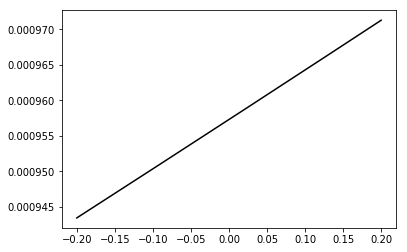

In [13]:
# Generates a probability distribution based on an array of numbers
kde = sp.gaussian_kde(np.array(simulated_asset_values[-1,:]))

#get probability from the integral of the assumed probability distribution from the ending asset values; from negative infinity to 80
merton_default_probability = kde.integrate_box_1d(-np.inf, 80)
print(merton_default_probability)

### (d) Black Cox Model: Stopping time of default

In [16]:
'''
V: Starting Firm Value @ t_0
K: Face Value of Debt @ T (Strike Price) 
sigma: The Volatility of Assets or Firm value for a specified time period
dt: Time Step
iRate: Quoted Annual Interest Rate
num_paths: The number of paths that will be simulated

Notes: Model starts with the given details of Firm value and then generates a monte carlo simulation based on the number of paths,
scaled volatility, time step and interest rate. The asset values at each path is then compared to the discounted face value of debt (K)
at each time step. If the Assets are less than the discounted fave value of debt then a default at t < T is flagged in a binary a matrix
'''

def black_cox_model(V, K, sigma, T, dt, iRate, num_paths):
    num_periods = int(T*dt**-1)
    #Creates a matrix filled with zeros; Rows: num_paths, Columns: num_periods
    asset_value = np.zeros((num_periods + 1, int(num_paths)))
    non_default_binary = np.zeros((num_periods + 1, int(num_paths)))
    asset_value[0] = V
    non_default_binary[0] = V >= K*np.exp(-iRate*T)
    for t in range(1, num_periods+1):
        if t > num_periods/2:
            sigma = .25
        # The stochastic equation for simulating the firm value
        asset_value[t] = asset_value[t-1]*np.exp((iRate -.5*sigma**2)*dt + sigma*np.random.randn(num_paths)*np.sqrt(dt))
        #checks to see if the current asset values are greater than the discounted Face value of debt
        non_default_binary[t] = asset_value[t] >= K*np.exp(-iRate*(T-(t/num_periods)))
        #temp_non_default_binary =  asset_value[t] >= K*np.exp(-iRate*(T-(t/240)))
        #previous_default_binary = non_default_binary[t] > non_default_binary[t-1]
        #non_default_binary[t] = np.logical_and(temp_non_default_binary, non_default_binary[t-1])
        
    # sums up all of the instances where there was not a default; ie. each row is equal to the num_periods + 1 if there was not a default
    binary_default_array = np.sum(non_default_binary, axis=0) == (num_periods+1)
    # Multiplies the binary non-default matrix with the asset values matrix at Time = T
    final_values = asset_value[-1,:] * binary_default_array
    return sp.gaussian_kde(final_values).integrate_box_1d(-np.inf, K)

black_cox_default_probability = black_cox_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)

print('Probability of defualt Model 2: ', black_cox_default_probability)

Probability of defualt Model 2:  0.36180715802361285


### (f) Changing the debt structure to equal out the probabilities

In [35]:
def merton_model_prob_default(V, K, sigma, T, dt, iRate, num_paths):
    num_periods = int(T*dt**-1)
    #Creates a matrix filled with zeros; Rows: num_paths, Columns: num_periods
    asset_value = np.zeros((num_periods + 1, int(num_paths)))
    asset_value[0] = V
    for t in range(1, num_periods+1):
        if t > num_periods/2:
            sigma = .25
        # The stochastic equation for simulating the firm value
        asset_value[t] = asset_value[t-1]*np.exp((iRate -.5*sigma**2)*dt + sigma*np.random.randn(num_paths)*np.sqrt(dt))
    # creates a PDF from the data and then integrates over that PDF from negative infinity to K to find the probability of falling in this region
    kde = sp.gaussian_kde(np.array(asset_value[-1,:]))
    return kde.integrate_box_1d(-np.inf, K)

def search_probability_merton(K):
    #kde = sp.gaussian_kde(np.array(simulated_asset_values[-1,:]))
    return sp.gaussian_kde(np.array(simulated_asset_values[-1,:])).integrate_box_1d(-np.inf, K)

'''
Sets up the optimization problem between the Merton and Black Cox Model.

The function takes the previously simulated values of the Merton Model and locks the PD.
A minimization objective function is run against the locked Merton PD and the variable Black Cox PD by changing the leverage amount
'''
def probability_errors(debt_level):
    black_cox= black_cox_model(V=100, K= debt_level, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)
    merton= merton_default_probability#search_probability_merton(debt_level)#merton_model_prob_default(V=100, K=debt_level, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)
    #merton_default_probability
    error = (merton - black_cox)**2
    print('Debt: ', debt_level, '\nError: ', error)
    return error

parameters = 80

In [36]:
res = minimize(fun=probability_errors, x0=parameters, bounds=((0, 200),))

Debt:  [80.] 
Error:  0.001611412653732734
Debt:  [80.00000001] 
Error:  0.0018500972501495087
Debt:  [0.] 
Error:  0.0958276038175308
Debt:  [1.e-08] 
Error:  0.09563736769296759
Debt:  [42.23787754] 
Error:  0.030275195039890953
Debt:  [42.23787755] 
Error:  0.030075872712710568
Debt:  [61.96225237] 
Error:  0.003908769066776603
Debt:  [61.96225238] 
Error:  0.0038796296418062916
Debt:  [73.60999994] 
Error:  2.3267173881490467e-05
Debt:  [73.60999995] 
Error:  2.1215208138949895e-05
Debt:  [77.86403086] 
Error:  0.0008588006492623841
Debt:  [77.86403087] 
Error:  0.0008427702267903853
Debt:  [79.26481669] 
Error:  0.00137065931562799
Debt:  [79.2648167] 
Error:  0.0014481723419407094
Debt:  [79.79148779] 
Error:  0.0016706467270623812
Debt:  [79.7914878] 
Error:  0.0015903597056103767
Debt:  [79.91806905] 
Error:  0.00175974678507364
Debt:  [79.91806906] 
Error:  0.0016852750574489804
Debt:  [79.96817209] 
Error:  0.001735286108166524
Debt:  [79.9681721] 
Error:  0.00173090266707804

In [37]:
#debt level of 53.36471269 for changing K for both models: 0.05% Error
#debt level of 75.009 for changing K only in BC to match the Locked K and values of Merton Model: 0.05% error
# Debt level of 73.6099 for changing K only in BC to match the Locked K value (80) of the Merton Model: 0.0023% error
#print('Debt Level where probability of defaults in Model 1 and 2 equal: ', res.x, '\n')
#optimized_debt_level = res.x
#print('Proabilty of default Model 1 under the optimized debt level: ', search_probability_merton(optimized_debt_level))
print(black_cox_model(V=100, K= 53.36471269, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000))
print(merton_model_prob_default(V=100, K= 53.36471269, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000))

print(black_cox_model(V=100, K= 75.009, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000))
print(merton_model_prob_default(V=100, K= 80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000))

Debt Level where probability of defaults in Model 1 and 2 equal:  [80.] 

Proabilty of default Model 1 under the optimized debt level:  0.319480198282876
0.20657559873792847
0.18794090090236654
0.33394228530096676
0.32086598795500315


### (h) Change in Defualt Probabilities with dt = 1

In [ ]:
print('Black Cox Default Probability (dt = 1/12): ', black_cox_default_probability, '\n')
print('Black Cox Default Probability (dt = 1): ', black_cox_model(V=100, K=80, sigma=.15, T=20, dt=1, iRate=0.031, num_paths=250000), '\n')
print('Merton Default Probability (dt = 1/12): ', merton_default_probability, '\n')
print('Merton Default Probability (dt = 1): ', merton_model_prob_default(V=100, K=80, sigma=.15, T=20, dt=1, iRate=0.031, num_paths=250000))

# (ii) Merton Model Credit Spreads

### (iii) Merton Model Extensions: Merton Model with Jump Processes